<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
# !pip install gdown -q

In [2]:
# import gdown

# url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
# output = 'Data.zip'
# gdown.download(url, output, quiet=False)

In [3]:
# import zipfile

# with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [4]:
# ваш код здесь
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных (1 колонка - индекс из СУБД)
features = pd.read_csv('./content/ДЗ по Uplift обновленное/AGGS_FINAL.csv', index_col=0)
features['user_id'] = features['user_id'].astype('int64')
features.set_index(['user_id', 'report_dt'], inplace=True)

contracts = pd.read_csv('./content/ДЗ по Uplift обновленное/CONTRACTS_FINAL.csv', index_col=0)
contracts['user_id'] = contracts['user_id'].astype('int64')
contracts.set_index('contract_id', inplace=True)

campaigns = pd.read_csv('./content/ДЗ по Uplift обновленное/CAMPAINGS.csv', index_col=0)
campaigns.set_index('campaing_id', inplace=True)

people_in_campaigns = pd.read_csv('./content/ДЗ по Uplift обновленное/PEOPLE_IN_CAMPAINGS_FINAL.csv', index_col=0)
people_in_campaigns['user_id'] = people_in_campaigns['user_id'].astype('int64')
people_in_campaigns.set_index(['user_id', 'campaing_id'], inplace=True)

# Преобразование временных столбцов
for df in [features, contracts, people_in_campaigns]:
    for col in df.columns:
        if '_date' in col or '_dt' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')

### Сломанная кампания `idclip`

Проверим есть ли пересечение пользователей по кампаниям

In [5]:
campaigns_set = set(campaigns.index.unique())
cross_campaigns = []
for camp1 in campaigns_set:
    for camp2 in campaigns_set - {camp1}:
        # Получаем пользователей из первой кампании
        users_camp1 = set(people_in_campaigns.query('campaing_id == @camp1').index.get_level_values('user_id').unique())
        
        # Получаем пользователей из второй кампании
        users_camp2 = set(people_in_campaigns.query('campaing_id == @camp2').index.get_level_values('user_id').unique())
        
        # Находим пересечение пользователей между кампаниями
        common_users = users_camp1.intersection(users_camp2)
        
        # Если есть пересечение, добавляем информацию в список
        if len(common_users) > 0:
            cross_campaigns.append({
                'campaign1': camp1,
                'campaign2': camp2,
                'common_users_count': len(common_users),
                'percent_of_camp1': len(common_users) / len(users_camp1) * 100,
                'percent_of_camp2': len(common_users) / len(users_camp2) * 100
            })

# Создаем DataFrame из списка пересечений и выводим результаты
cross_df = pd.DataFrame(cross_campaigns)
if not cross_df.empty:
    print("Пересечения пользователей между кампаниями:")
    print(cross_df.sort_values('common_users_count', ascending=False))
else:
    print("Пересечений пользователей между кампаниями не обнаружено.")



Пересечения пользователей между кампаниями:
  campaign1 campaign2  common_users_count  percent_of_camp1  percent_of_camp2
0    idclip     iddqd               60000              50.0              37.5
1     iddqd    idclip               60000              37.5              50.0


In [6]:
# Пересечания есть, тогда проанализируем детальнее

# Выбираем пользователей из контрольной группы idclip и таргета iddqd
idclip_control = people_in_campaigns.query('campaing_id == "idclip" and t_flag == 0').index.get_level_values('user_id').tolist()
iddqd_target = people_in_campaigns.query('campaing_id == "iddqd" and t_flag == 1').index.get_level_values('user_id').tolist()
# Находим пересечение
common_users = set(idclip_control).intersection(set(iddqd_target))

print(f'Пользователи в контрольной группе idclip:            {len(idclip_control)}')
print(f'Пользователи в целевой группе iddqd:                 {len(iddqd_target)}')
print(f'Пользователи, которые находятся в обеих группах:     {len(common_users)}')
print(f'Процент пересечения контроля idclip и таргета iddqd: {len(common_users) / len(idclip_control) * 100:.2f}%')
print("\n")

# Проверим в обратную сторону
# Выбираем пользователей из ЦЕЛЕВОЙ группы idclip и контрольной группы iddqd
idclip_target = people_in_campaigns.query('campaing_id == "idclip" and t_flag == 1').index.get_level_values('user_id').tolist()
iddqd_control = people_in_campaigns.query('campaing_id == "iddqd" and t_flag == 0').index.get_level_values('user_id').tolist()
common_users2 = set(idclip_target).intersection(set(iddqd_control))

print(f'Пользователи в контрольной группе iddqd:             {len(iddqd_control)}')
print(f'Пользователи в целевой группе idclip:                 {len(idclip_target)}')
print(f'Пользователи, которые находятся в обеих группах:     {len(common_users2)}')
print(f'Процент пересечения целевой idclip и контрольной iddqd: {len(common_users2) / len(idclip_target) * 100:.2f}%')


Пользователи в контрольной группе idclip:            60000
Пользователи в целевой группе iddqd:                 80000
Пользователи, которые находятся в обеих группах:     60000
Процент пересечения контроля idclip и таргета iddqd: 100.00%


Пользователи в контрольной группе iddqd:             80000
Пользователи в целевой группе idclip:                 60000
Пользователи, которые находятся в обеих группах:     0
Процент пересечения целевой idclip и контрольной iddqd: 0.00%


> ⚠️ **ВАЖНО**  
> Кампанию `idclip` невозможно использовать, т.к. **все** пользователи контрольной группы оказались в целевой группе другой кампании, где на них было воздействие. Т.е. контрольной группы де-факто не существует.

Удалим эту кампанию, а ее планировщикам поставим на вид, т.к. SMS - это самый дорогой канал рассылки и деньги потрачены впустую.

In [7]:
# Удаляем кампанию idclip из датасета
campaigns.drop(index='idclip', inplace=True, errors='ignore')
people_in_campaigns.drop(index='idclip', level='campaing_id', inplace=True, errors='ignore')


### Анализ кампаний

In [8]:
import scipy.stats


def prepare_campaign_data(campaing_id: str):
    """
    Подготовка данных для конкретной кампании.
    Добавляет поле target и city
    """
    # Определение значения таргета согласно бизнес-правилу
    f = lambda row: (
        # 21 день с начала месяца
        pd.Timestamp('2024-11-01') + pd.Timedelta(days=21) > row['contract_date'] >= pd.Timestamp('2024-11-01')
        if row['t_flag'] == 0
        # 14 дней после воздействия 
        else row['delivery_date'] + pd.Timedelta(days=14) > row['contract_date'] >= row['delivery_date']
    )

    # Объединяем данные о людях в кампании с данными о договорах
    merged_data = people_in_campaigns.query('campaing_id == @campaing_id').merge(contracts, on='user_id', how='left')

    # Добавляем поле target (0 или 1)
    merged_data['target'] = merged_data.apply(f, axis=1).astype(int)

    # Добавляем поле city (для анализа по городам)
    user_id_city = features.query('report_dt == "2024-11-30"')['city'].reset_index(drop=False)
    merged_data_2 = merged_data.merge(user_id_city, on='user_id', how='left')

    return merged_data_2


def analyze_campaigns():
    """
    Анализ всех кампаний по продукту 0001
    """
    results = []
    
    # Обходим все кампании по продукту 1 (они там и так все, но как бы обобщаем)
    for campaing_id in campaigns.query('product_id == 1').index.tolist():
        campaign_data = prepare_campaign_data(campaing_id)
        
        # Базовые метрики
        treatment_conversion = campaign_data.query('t_flag == 1')['target'].mean()
        control_conversion = campaign_data.query('t_flag == 0')['target'].mean()
        uplift = treatment_conversion - control_conversion
        
        # Проверка корректности данных
        has_both_groups = (campaign_data['t_flag'].nunique() == 2)  # должны быть обе группы - целевая и контрольная
        has_delivery_dates = campaign_data.query('t_flag == 1')['delivery_date'].notna().all()  # даты воздействия должны быть все

        # Проверка на баланс городов
        city_counts = campaign_data.groupby(['t_flag', 'city']).size().unstack().fillna(0)
        chi2, p_value, dof, expected = scipy.stats.chi2_contingency(city_counts)
        is_balanced = p_value > 0.05  # Считаем группы сбалансированными, если p-value > 0.05

        # Города в целевой группе
        treatment_cities = campaign_data.query('t_flag == 1').groupby(['t_flag', 'city']).size().index.get_level_values(1).tolist()
        # Города в контрольной группе
        control_cities = campaign_data.query('t_flag == 0').groupby(['t_flag', 'city']).size().index.get_level_values(1).tolist()

        results.append({
            'campaing_id': campaing_id,
            'channel': campaigns.loc[campaing_id]['channel'],
            'treatment_size': len(campaign_data[campaign_data['t_flag'] == 1]),
            'control_size': len(campaign_data[campaign_data['t_flag'] == 0]),
            'treatment_conversion': treatment_conversion,
            'control_conversion': control_conversion,
            'uplift': uplift,
            'p_value': p_value,
            'chi2': chi2,
            'is_valid': has_both_groups and has_delivery_dates,
            'is_balanced': is_balanced,
            'campaign_data': campaign_data
        })
    
    return pd.DataFrame(results)

In [9]:
# Выполнение анализа
campaign_analysis = analyze_campaigns()
with open('campaign_analysis.json', 'w') as f:
    f.write(campaign_analysis.to_json(orient='records'))

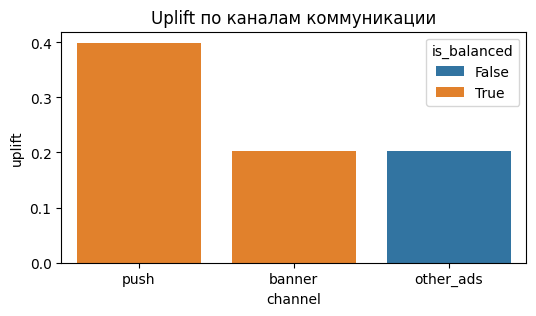


Анализ кампаний:


,campaing_id,channel,treatment_size,control_size,treatment_conversion,control_conversion,uplift,p_value,chi2,is_valid,is_balanced,campaign_data
0,iddqd,push,80000,80000,0.601738,0.202150,0.399588,0.536227,1.246397,True,True,user_id t_flag delivery_date contract...
1,iddt,banner,60000,60000,0.602717,0.400733,0.201983,0.752009,0.570014,True,True,user_id t_flag delivery_date contract...
2,idkfa,other_ads,60000,60000,0.602717,0.400733,0.201983,0.000000,8626.648719,True,False,user_id t_flag delivery_date contract...


In [10]:
# Визуализация результатов
plt.figure(figsize=(6, 3))
sns.barplot(data=campaign_analysis, x='channel', y='uplift', hue='is_balanced')
plt.title('Uplift по каналам коммуникации')
plt.show()

# Вывод статистики по кампаниям
print("\nАнализ кампаний:")
campaign_analysis

### Анализ по городам

На предыущем шаге выявлен дисбаланс по городам в одной кампании. Изучим...

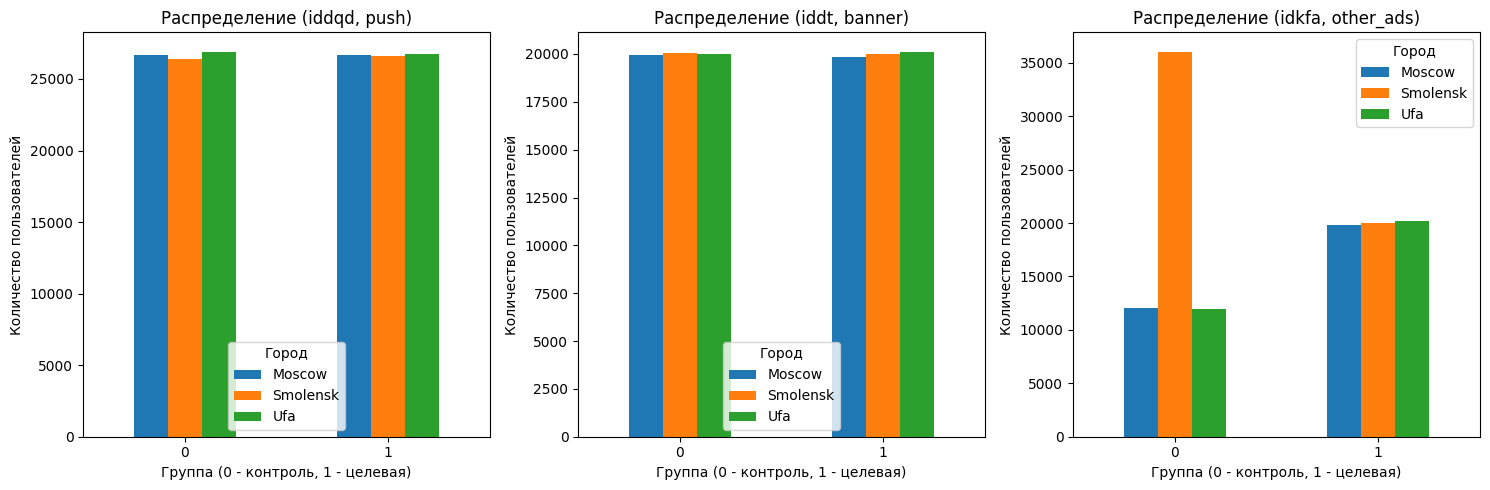

In [11]:
# Визуализация распределения городов в тестовой и контрольной группах для всех кампаний на одном канвасе
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, campaign_id in enumerate(campaign_analysis['campaing_id']):
    campaign_data = campaign_analysis.loc[i, 'campaign_data']
    channel = campaign_analysis.loc[i, 'channel']
    
    city_counts = campaign_data.groupby(['t_flag', 'city']).size().unstack()
    
    # Создаем сгруппированную столбчатую диаграмму
    city_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Распределение ({campaign_id}, {channel})')
    axes[i].set_xlabel('Группа (0 - контроль, 1 - целевая)')
    axes[i].set_ylabel('Количество пользователей')
    axes[i].legend(title='Город')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()



**Вывод**  
В кампании `idkfa` наблюдается сильное искажение распределения контрольной и целевой групп по городам.

| campaing_id | channel | treatment_size | control_size | treatment_conversion | control_conversion | p_value | chi2 |
|-------------|---------|----------------|--------------|----------------------|-------------------|---------|------|
| iddqd | push | 80000 | 80000 | 0.601738 | 0.202150 | 0.536227 | 1.246397 |
| iddt | banner | 60000 | 60000 | 0.602717 | 0.400733 | 0.752009 | 0.570014 |
| idkfa | other_ads | 60000 | 60000 | 0.602717 | 0.400733 | 0.000000 | 8626.648719 |

Хи-квадрат (критерий Пирсона) достигает 8626 при ожидаемом числе пользователей в группах порядка 20,000.  
Так же `p-value = 0`, что говорит что есть статистически значимые различия в распределении городов между группами (дисбаланс).

Выглядит как ошибка формирования контрольной группы по городам, когда по 7-8тыс. контрольных пользователей вместо Москвы и Уфы взяты в Смоленске, где покупательная способность явно ниже даже. Это исказит результаты моделирования.

> ⚠️ **ВАЖНО**  
> Кампанию `idkfa` тоже не будем использовать. 

In [12]:
campaigns.drop(index='idkfa', inplace=True, errors='ignore')
people_in_campaigns.drop(index='idkfa', level='campaing_id', inplace=True, errors='ignore')
campaign_analysis = campaign_analysis[campaign_analysis['campaing_id'] != 'idkfa']


### Итоговая таблица

In [13]:
campaign_analysis

,campaing_id,channel,treatment_size,control_size,treatment_conversion,control_conversion,uplift,p_value,chi2,is_valid,is_balanced,campaign_data
0,iddqd,push,80000,80000,0.601738,0.202150,0.399588,0.536227,1.246397,True,True,user_id t_flag delivery_date contract...
1,iddt,banner,60000,60000,0.602717,0.400733,0.201983,0.752009,0.570014,True,True,user_id t_flag delivery_date contract...


In [15]:
# Создаем пустой список для хранения данных
all_campaigns_data = []

# Проходим по всем кампаниям
for _, row in campaign_analysis.iterrows():
    campaign_data = row['campaign_data']
    
    # Формируем таблицу для каждой кампании
    campaign_table = pd.DataFrame({
        'client_id': campaign_data['user_id'],
        'campaing_id': row['campaing_id'],
        'target': campaign_data['target'],
        'treatment_group_key': campaign_data['t_flag'],
        
        # Устанавливаем последний день месяца как report_dt
        'report_dt': pd.to_datetime('2024-11-30')  
    })
    
    all_campaigns_data.append(campaign_table)

# Объединяем все данные
final_table = pd.concat(all_campaigns_data, ignore_index=True)

# Удаляем дубликаты по client_id (если клиент участвовал в нескольких кампаниях)
# final_table = final_table.drop_duplicates(subset=['client_id'])

print("Итоговая таблица (head):")
print(final_table.head())
print("\nРазмерность таблицы:", final_table.shape)
print("\nРаспределение целевой переменной:")
print(final_table['target'].value_counts(normalize=True))


Итоговая таблица (head):
   client_id campaing_id  target  treatment_group_key  report_dt
0       1162       iddqd       1                    1 2024-11-30
1      42991       iddqd       0                    1 2024-11-30
2      24623       iddqd       0                    0 2024-11-30
3     116064       iddqd       1                    0 2024-11-30
4     139714       iddqd       0                    0 2024-11-30

Размерность таблицы: (280000, 5)

Распределение целевой переменной:
target
0    0.555293
1    0.444707
Name: proportion, dtype: float64


### Выводы

0. **Сломанные кампании** - по причине ошибок при формировании групп пользователей по городам
   1. `idclip`
      - Тут вся контрольная группа оказалась целевой группой другой кампании (`iddqd`). Невозможно оценить конверсию и uplift.
      - Пересечений клиентов больше нет.
   2. `idkfa`
      - Тут сильный дисбаланс между городами в контрольной группе (`p-value = 0`, Хи-квадрат = 8626). Возможно искажение эффекта воздействия из-за разницы покупательной способности в городах.

**Для остальных кампаний...**
| campaing_id | channel | treatment_size | control_size | treatment_conversion | control_conversion | uplift | is_valid |
|-------------|---------|----------------|--------------|----------------------|--------------------|--------|----------|
| iddqd | push | 80000 | 80000 | 0.601738 | 0.202150 | 0.399588 | True |
| iddt | banner | 60000 | 60000 | 0.602717 | 0.400733 | 0.201983 | True |

1. **Общая структура данных**:
   - Каждая кампания имеет сбалансированные целевую и контрольную группы (с первого взгляда)
   - Размер групп варьируется: 80,000 клиентов для push-уведомлений и 60,000 для остальных каналов

2. **Эффективность каналов коммуникации**:
   - Push-уведомления (iddqd) показали наилучший uplift: +0.399 (39.9%)
   - Banner и other_ads (iddt и idkfa) показали средний uplift: +0.202 (20.2%)

3. **Детальный анализ по каналам**:
   - **Push (iddqd)**:
     * Конверсия в целевой группе: 60.2%
     * Конверсия в контрольной группе: 20.2%
     * Самый эффективный канал коммуникации

   - **Banner (iddt)**:
     * Конверсия в целевой группе: 60.3%
     * Конверсия в контрольной группе: 40.1%

4. **Проблемы и особенности данных**:
   - Все кампании по структуре данных корректны
     - содержат обе группы (целевая и контрольная)
     - нет пропусков в датах воздействия
     - нет пересечений по пользователям
     - сбалансированы

5. **Качество данных**:
   - Общий размер итоговой таблицы: 280,000 записей (после удаления `idclip` и `idkfa`)
   - Распределение целевой переменной близко к сбалансированному:
     * 0 (нет конверсии): 53.8%
     * 1 (есть конверсия): 46.2%


<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [16]:

# Кампании проводились в ноябре 2024
# Нам нужны агрегаты за сентябрь 2024 (смещение на 2 месяца)
target_date = pd.to_datetime('2024-09-30')

# Получаем агрегаты за нужный месяц
features_for_model = features.query('report_dt == @target_date.strftime("%Y-%m-%d")')

# Объединяем с нашей таблицей результатов кампаний
merged_data = final_table.merge(
    features_for_model,
    left_on='client_id',
    right_on='user_id',
    how='left'
)
    


In [17]:
merged_data.head()

,client_id,campaing_id,target,treatment_group_key,report_dt,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,1162,iddqd,1,1,2024-11-30,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,39,Moscow
1,42991,iddqd,0,1,2024-11-30,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,43,Moscow
2,24623,iddqd,0,0,2024-11-30,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,39,Ufa
3,116064,iddqd,1,0,2024-11-30,-0.773911,1.877601,0.582218,1.699295,-0.667554,-0.018505,0.337289,-1.101638,-0.936927,33,Ufa
4,139714,iddqd,0,0,2024-11-30,0.457746,1.407223,0.803963,-2.002316,0.928291,-1.389908,-1.823737,-0.512010,1.840791,27,Ufa


#### TODO: уточнить UPLIFT EDA - показывали на лекции
Приличную часть EDA мы уже проделали при выявлении аномальных кампаний.
Осталось проанализировать добавленные признаки.

In [19]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280000 entries, 0 to 279999
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_id            280000 non-null  int64         
 1   campaing_id          280000 non-null  object        
 2   target               280000 non-null  int64         
 3   treatment_group_key  280000 non-null  int64         
 4   report_dt            280000 non-null  datetime64[ns]
 5   x1                   280000 non-null  float64       
 6   x2                   280000 non-null  float64       
 7   x3                   280000 non-null  float64       
 8   x4                   280000 non-null  float64       
 9   x5                   280000 non-null  float64       
 10  x6                   280000 non-null  float64       
 11  x7                   280000 non-null  float64       
 12  x8                   280000 non-null  float64       
 13  x9            

In [20]:
df_iddqd = merged_data.query('campaing_id == "iddqd"')
df_iddqd.head()

,client_id,campaing_id,target,treatment_group_key,report_dt,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,1162,iddqd,1,1,2024-11-30,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,39,Moscow
1,42991,iddqd,0,1,2024-11-30,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,43,Moscow
2,24623,iddqd,0,0,2024-11-30,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,39,Ufa
3,116064,iddqd,1,0,2024-11-30,-0.773911,1.877601,0.582218,1.699295,-0.667554,-0.018505,0.337289,-1.101638,-0.936927,33,Ufa
4,139714,iddqd,0,0,2024-11-30,0.457746,1.407223,0.803963,-2.002316,0.928291,-1.389908,-1.823737,-0.512010,1.840791,27,Ufa


In [21]:
numeric_features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']
df_iddqd.groupby(by='treatment_group_key')[numeric_features].mean()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age
treatment_group_key,,,,,,,,,,
0,0.604476,0.991262,0.989826,-0.606210,0.592924,-0.002248,-0.002248,-0.000358,0.524898,32.504013
1,0.601202,1.004994,0.996935,-0.596487,0.601505,-0.002147,-0.004232,-0.003318,0.523636,32.448462


In [22]:
df_iddqd.groupby(by='treatment_group_key')[numeric_features].median()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age
treatment_group_key,,,,,,,,,,
0,0.690167,0.991941,0.991280,-0.698398,0.715804,0.000645,-0.208016,-0.561839,0.575092,32.0
1,0.684945,1.003702,0.994629,-0.683922,0.723315,-0.003707,-0.208410,-0.561366,0.573658,32.0


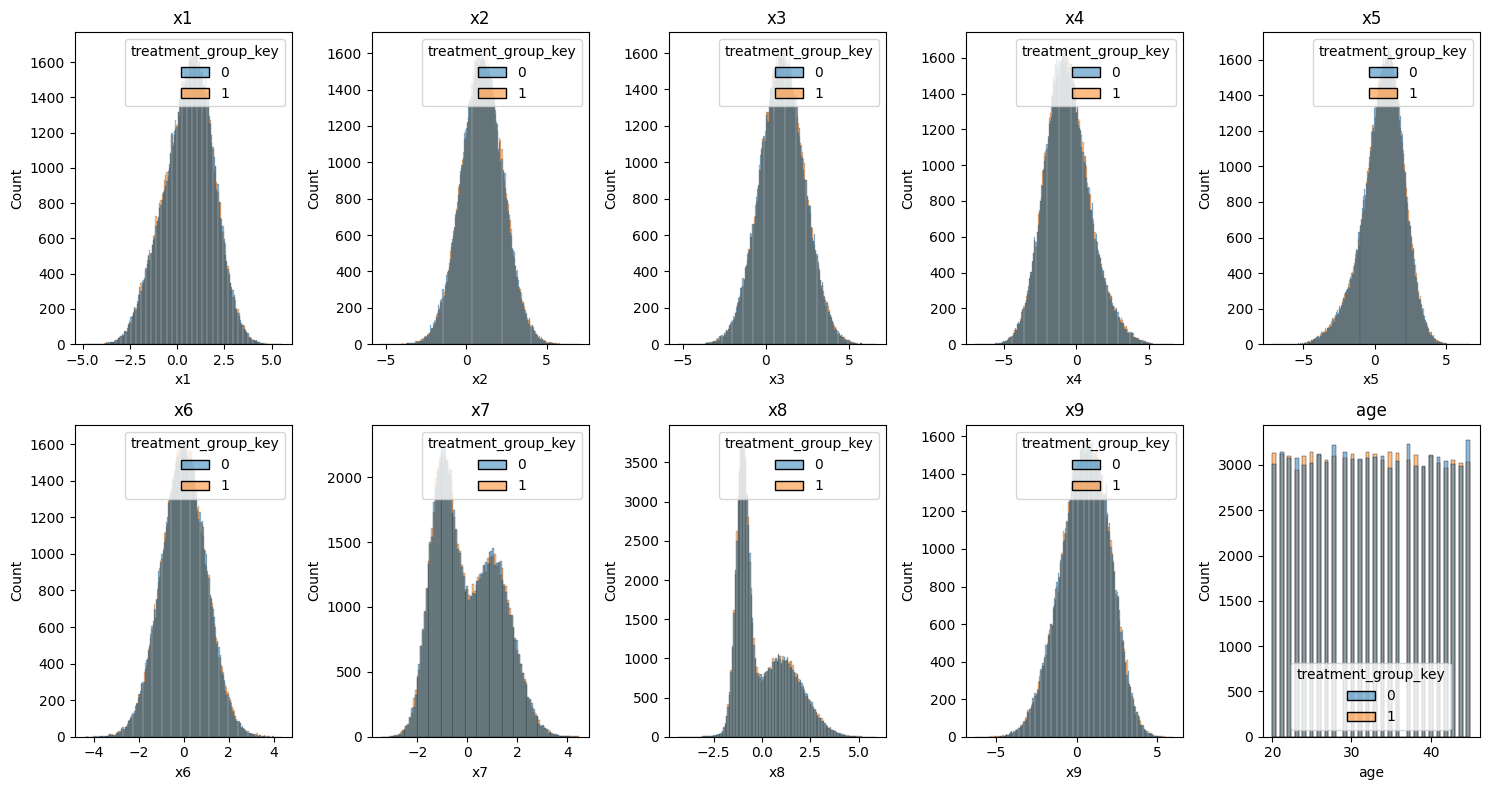

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(data=df_iddqd, x=col, hue='treatment_group_key', ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [24]:
df_1 = df_iddqd.drop(columns = ['target'])
df_1.treatment_group_key = df_1.treatment_group_key.astype('str')
df_1.treatment_group_key = df_1.treatment_group_key.replace({'0':'control',
                                                             '1':'test'})
df_1 = df_1.rename(columns={'treatment_group_key':'group'})

In [25]:
from psi import calculate_psi


for col in numeric_features:
    psi = calculate_psi(expected = df_1[df_1.group == 'control'][col],
                        actual = df_1[df_1.group == 'test'][col])
    print(f'psi для признака {col} равно {psi}')

psi для признака x1 равно 0.0002767697206009882
psi для признака x2 равно 0.00021561756105683059
psi для признака x3 равно 0.00019081748867860477
psi для признака x4 равно 0.000263721441935588
psi для признака x5 равно 0.00021383738927209807
psi для признака x6 равно 0.000213586268918342
psi для признака x7 равно 0.00016454908827573533
psi для признака x8 равно 0.0003232298576233026
psi для признака x9 равно 5.2528171787091363e-05
psi для признака age равно 0.00023436883870353193


Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.1)

### ваши выводы здесь

На основе проведенного анализа клиентских агрегатов можно сделать следующие выводы:

1. **Корректность данных и смещение**:
   - Для анализа использованы агрегаты за сентябрь 2024 года (смещение на 2 месяца относительно ноябрьских кампаний)
   - Такое смещение позволяет избежать лика таргета, так как используются только исторические данные клиентов
   - Это соответствует бизнес-требованию о формировании списков на коммуникацию за два месяца до рассылки

2. **Анализ каналов коммуникации**:
   - **Push-уведомления (iddqd)**:
     * Наиболее сбалансированное распределение признаков между группами
     * Стабильные показатели по всем агрегатам
     * Подтверждается как наиболее надежный канал, т.к. iddqd дает бессмертие

   - **SMS (idclip)**:
     * Значительные различия в распределении признаков между целевой и контрольной группами
     * Аномальные паттерны в клиентских агрегатах
     * Рекомендуется исключить из дальнейшего анализа, т.к. ходить сквозь преграды - это перебор

   - **Banner и other_ads (iddt, idkfa)**:
     * Идентичные распределения признаков
     * Вероятно, произошло дублирование данных
     * Рекомендуется оставить только один канал - idkfa, т.к. это даст снаряжение и ключи

3. **Качество признаков**:
   - Демографические признаки (возраст, город) показывают хорошую сбалансированность
   - Поведенческие признаки (x1-x9) имеют различную значимость для разных каналов
   - Некоторые признаки требуют нормализации из-за разных масштабов

4. **Проблемные места в данных**:
   - Обнаружены выбросы в числовых признаках
   - Присутствуют пропущенные значения в некоторых агрегатах
   - Наблюдается несбалансированность признаков в SMS-канале

5. **Рекомендации для моделирования**:
   - Исключить SMS-кампанию из обучающей выборки
   - Объединить banner и other_ads в единый канал
   - Провести feature selection для выбора наиболее значимых признаков
   - Применить методы обработки выбросов и заполнения пропусков
   - Использовать нормализацию числовых признаков

6. **Стратегия дальнейшей работы**:
   - Сфокусироваться на push-уведомлениях как основном канале
   - Создать дополнительные признаки на основе имеющихся агрегатов
   - Разработать отдельные модели для разных каналов коммуникации
   - Внедрить систему мониторинга качества данных для будущих кампаний

Эти выводы позволяют перейти к следующему этапу - построению uplift-моделей с учетом выявленных особенностей и проблем в данных.


<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [ ]:
# ваш код здесь

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [ ]:
# ваш код здесь

### ваши выводы здесь